#### preprocessing images for ocr

In [5]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
from pytesseract import Output
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\giova\AppData\Local\Tesseract-OCR\tesseract.exe'

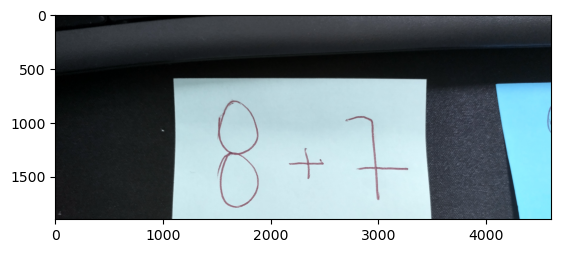

In [6]:
## 0. opening an image:

image_file = 'teste/1.jpg'
img = cv.imread(image_file)
plt.imshow(img, 'gray', vmin=0, vmax=255)

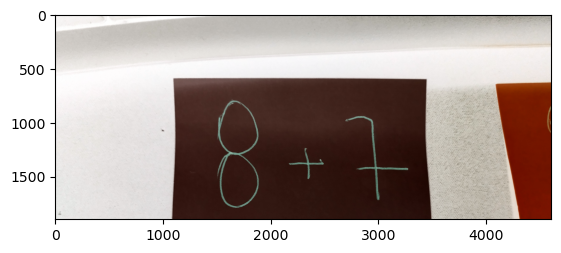

In [7]:
## 1. inverted images
inverted_image = cv.bitwise_not(img)
cv.imwrite('inverted.jpg', inverted_image)
plt.imshow(inverted_image, 'gray', vmin=0, vmax=255)

In [8]:
## 02. rescaling

In [9]:
## 03. binarization
def grayscale(image):
    return cv.cvtColor(image, cv.COLOR_BGR2GRAY)

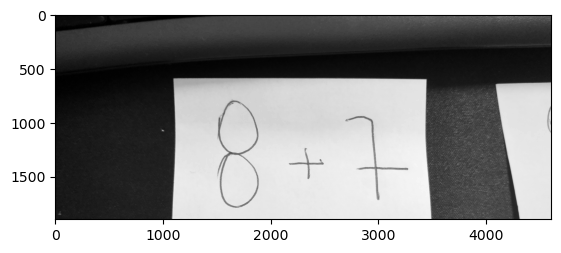

In [10]:
gray_image = grayscale(img)
cv.imwrite('gray.jpg', gray_image)
plt.imshow(gray_image, 'gray', vmin=0, vmax=255)

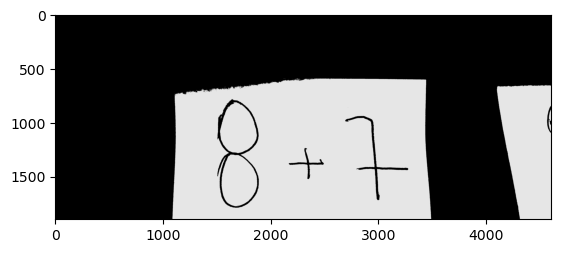

In [11]:
thresh, im_bw = cv.threshold(gray_image, 200, 230, cv.THRESH_BINARY)
cv.imwrite('bw_image.jpg', im_bw)
plt.imshow(im_bw, 'gray', vmin=0, vmax=255)

In [12]:
## 04. noise removal
def noise_removal(image):
    kernel = np.ones((1, 1), np.uint8)
    image = cv.dilate(image, kernel, iterations=2)
    kernel = np.ones((1, 1), np.uint8)
    image = cv.erode(image, kernel, iterations=1)
    image = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel)
    image = cv.medianBlur(image, 3)
    return (image)

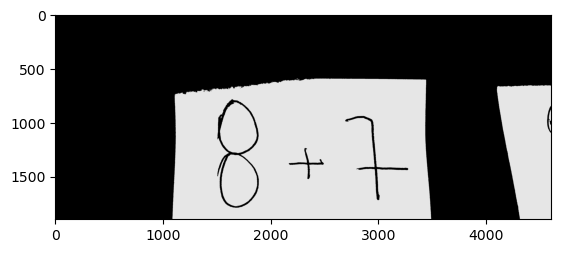

In [13]:
no_noise = noise_removal(im_bw)
plt.imshow(no_noise, 'gray', vmin=0, vmax=255)

In [14]:
## 05. dilation and erosion
def thin_font(image):
    image = cv.bitwise_not(image)
    kernel = np.ones((2,2), np.uint8)
    image = cv.erode(image, kernel, iterations=1)
    image = cv.bitwise_not(image)
    return (image)

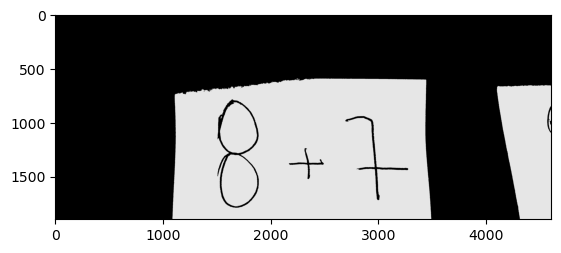

In [15]:
eroded_image = thin_font(no_noise)
plt.imshow(eroded_image, 'gray', vmin=0, vmax=255)

In [16]:
## 05. dilation and erosion
def thick_font(image):
    image = cv.bitwise_not(image)
    kernel = np.ones((2,2), np.uint8)
    image = cv.dilate(image, kernel, iterations=10)
    image = cv.bitwise_not(image)
    return (image)

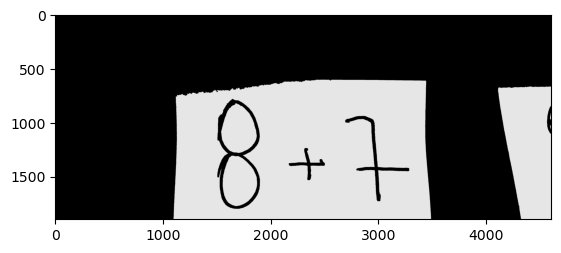

In [17]:
dilated_image = thick_font(no_noise)
plt.imshow(dilated_image, 'gray', vmin=0, vmax=255)

In [18]:
### 06. rotation / deskewing
### não deve ter bordas! remover bordas deve vir primeiro
new = cv.imread('teste/8.jpg')

def getSkewAngle(cvImage) -> float:
    newImage = cvImage.copy()
    gray = cv.cvtColor(newImage, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (9, 9), 0)
    thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (30, 5))
    dilate = cv.dilate(thresh, kernel, iterations=2)
    
    contours, hierarchy = cv.findContours(dilate, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv.contourArea, reverse=True)
    for c in contours:
        rect = cv.boundingRect(c)
        x, y, w, h = rect
        cv.rectangle(newImage, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    largestContour = contours[0]
    print(len(contours))
    minAreaRect = cv.minAreaRect(largestContour)
    cv.imwrite('boxes.jpg', newImage)
    
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle

def rotateImage(cvImage, angle:float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w//2, h//2)
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv.warpAffine(newImage, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)
    return newImage

In [19]:
def deskew (cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

8


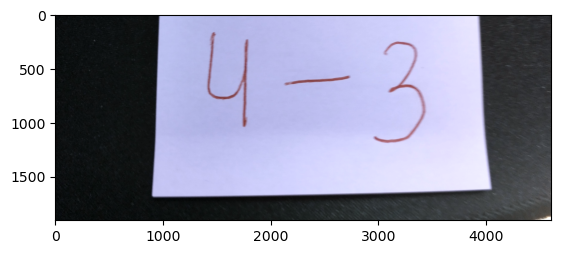

In [20]:
fixed = deskew(new)
plt.imshow(fixed, 'gray', vmin=0, vmax=255)

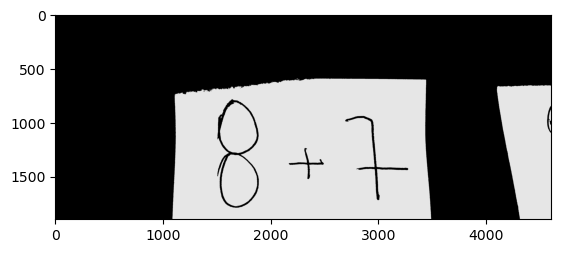

In [21]:
## 07. removing borders
plt.imshow(no_noise, 'gray', vmin=0, vmax=255)

In [22]:
def remove_borders(image):
    contours, hierarchy = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cntSorted = sorted(contours, key=lambda x:cv.contourArea(x))
    cnt = cntSorted[-1] # get the largest bouding box
    x, y, w, h = cv.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return (crop)

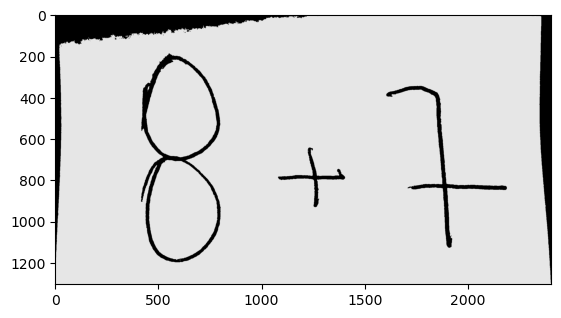

In [23]:
no_borders = remove_borders(no_noise)
plt.imshow(no_borders, 'gray', vmin=0, vmax=255)

In [24]:
### 08. missing borderd
color = [0, 0, 0]
top, bottom, left, right = [150] * 4

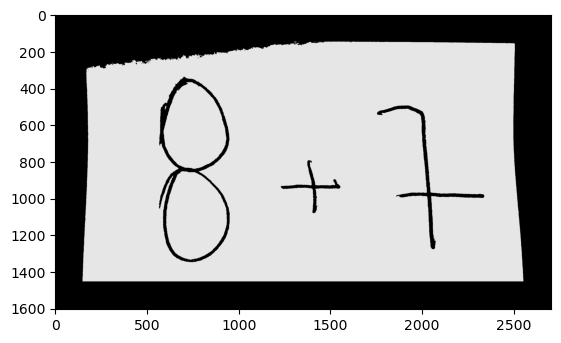

In [25]:
image_with_border = cv.copyMakeBorder(no_borders, top, bottom, left, right, cv.BORDER_CONSTANT, value=color)
cv.imwrite('img24.png', image_with_border)
plt.imshow(image_with_border, 'gray', vmin=0, vmax=255)

In [26]:
## tentando encontrar números
myconfig = r"--psm 11 --oem 3"
data = pytesseract.image_to_data(image_with_border, lang='eng+equ', config=myconfig, output_type=Output.DICT)

In [28]:
# Não reconhece nenhum numero
data

{'level': [1],
 'page_num': [1],
 'block_num': [0],
 'par_num': [0],
 'line_num': [0],
 'word_num': [0],
 'left': [0],
 'top': [0],
 'width': [2704],
 'height': [1604],
 'conf': [-1],
 'text': ['']}